# **Modeling E-I neural circuit using MNN**

This tutorial explains how to use the MNN to implement the classic excitation-inhibition neural circuit by Brunel (2000).

- Brunel, N. Dynamics of Sparsely Connected Networks of Excitatory and Inhibitory Spiking Neurons. *J. Comput. Neurosci.* **8**, 183–208 (2000).

The main advantage of the MNN is that it captures the coupling of firing statistics between individual neurons in a large network, whereas previous works have to resort to population-averaged statistics, assuming homogeneity.

We can describe the dynamics of the first two moments of neural firing using a recurrent MNN as

$\tau\dfrac{d\mu_i}{dt} = -\mu_i + \phi_{\rm mean}(\bar{\mu}_i,\bar{\sigma}_i^2)$

$\tau\dfrac{d\sigma_i^2}{dt} = -\sigma_i^2 + \phi_{\rm var}(\bar{\mu}_i,\bar{\sigma}_i^2)$

where $\bar{\mu}_i = \sum_j W_{ij}\mu_j+\bar{\mu}_{\rm ext}$ and $\bar{\sigma}^2_i = \sum_j W_{ij}^2\sigma^2_j+\bar{\sigma}^2_{\rm ext}$ are the mean and variance of the total synaptic current. The nonlinear mappings $\phi_{\rm mean}$ and $\phi_{\rm var}$ are the moment activation (see tutorial on moment activation). In this sparsely connected network, the noise correlations between neurons are extremely weak so we ignore the covariance and only calculate the variance.


We will implement this model with PyTorch to take advantage of GPU acceleration but the code also runs without GPU (simply set `device='cpu'` in the config).

You need to copy this notebook to the root directory (under `moment-neural-network`).

First, the necessary imports.

In [102]:
import torch
from mnn.mnn_core.mnn_utils import Mnn_Core_Func
import numpy as np
from pprint import pprint
from matplotlib import pyplot as plt

We define a helper function that outputs a dictionary containing all parameters of the model.

In [ ]:
def gen_config(N=12500, ie_ratio=4.0, w=0.1, w_ext=0.1, device='cpu'):    
    config = {
    'Vth': 20, #mV, firing threshold, default 20
    'Vres': 0, #mV reset potential; default 0
    'Tref': 5, #ms, refractory period, default 5
    'NE': int(0.8*N), # number of excitatory neurons
    'NI': int(0.2*N), # number of inhibitory neurons
    'ie_ratio': ie_ratio,  #ratio between I/E synaptic weights
    'wee':w, # E-to-E weights
    'wei':-w*ie_ratio, #I-to-E weights
    'wie':w, # E-to-I weights
    'wii':-w*ie_ratio, # I-to_I weights
    'w_ext': w_ext, # external excitatory weight
    'conn_prob': 0.1, #connection probability
    'dt':0.1, # integration time step for mnn (a.u.)
    'T':10, #simualtion duration (a.u.)
    'device': device,
    'tau': 1, # time constant in MNN (a.u.)
    }
    return config

config = gen_config(N=1250, ie_ratio=4.0, w=1.0, w_ext=0.1, device='cuda')
pprint(config)

{'NE': 1000,
 'NI': 250,
 'T': 10,
 'Tref': 5,
 'Vres': 0,
 'Vth': 20,
 'conn_prob': 0.1,
 'device': 'cuda',
 'dt': 0.1,
 'ie_ratio': 4.0,
 'record_ts': False,
 'tau': 1,
 'w_ext': 0.1,
 'wee': 1.0,
 'wei': -4.0,
 'wie': 1.0,
 'wii': -4.0}


Next, we define the recurrent connectivity of the neural circuit. The circuit consists of `NE` excitatory neurons and `NI` inhibitory neurons. The strength of excitatory/inhibitory synaptic weights are constants. The connections are drawn randomly with a probability specified by `conn_prob`.

In [ ]:
def gen_synaptic_weight(config):
    Ne = config['NE']
    Ni = config['NI']
    N = Ne + Ni
    
    W = torch.randn(N, N)
    coin_toss = torch.rand(N, N)

    # Excitatory weight
    W[:Ne, :Ne] = config['wee']
    W[Ne:, :Ne] = config['wie']
    # Inhibitory weight
    W[:Ne, Ne:] = config['wei']
    W[Ne:, Ne:] = config['wii']
    
    # Apply connection probability
    W[coin_toss > config['conn_prob']] = 0
    # Remove diagonal (self-connection)
    W.fill_diagonal_(0)
    
    return W.to(config['device'])

W = gen_synaptic_weight(config)
print(W.shape)

torch.Size([1250, 1250])


Next, we define a generator for the external input. Here, we consider independent Poisson spike trains with excitatory synapses. The method `InputGenerator().uncorr_input` outputs the mean and variance of the total external synaptic current. They are 2D arrays, with the 0th dimension reserved for the batch dimension (to efficiently utilize GPU acceleration), and the 1th dimension corresponding to the number of neurons. 

Here, we use the batch dimension to implement multiple trials with different input strengths. But you may also use it to parallelize trials that varies other parameters (or combinations of parameters).

In [105]:
class InputGenerator():
    def __init__(self, config):
        self.NE = config['NE']
        self.NI = config['NI']
        self.N = config['NE']+config['NI']
        self.w_ext = config['w_ext']
        self.device = config['device']        
        return

    def uncorr_input(self, input_rate_array):
        # input argument dimensions: batchsize x #neurons
        input_mean = self.w_ext*input_rate_array*torch.ones(1,self.N, device=self.device) #input current mean        
        input_var = self.w_ext*self.w_ext*input_rate_array*torch.ones(1,self.N, device=self.device)
        return input_mean, input_var                   

input_gen = InputGenerator(config)
input_rate_array = torch.linspace(0,40,11, device=config['device']).unsqueeze(1)

input_mean, input_var = input_gen.uncorr_input(input_rate_array)
print(input_mean.shape)
print(input_var.shape)

torch.Size([11, 1250])
torch.Size([11, 1250])


Given the recurrent weights and the external inputs specified, we can now define the recurrent MNN model. Note that in practice, the synaptic summation is implemented as a right multiplication with the weight matrix transposed. This is because the 0th dimension is reserved for batch (trial) dimension. For simplicity, this implementation does not consider synaptic delay.

In [ ]:
class RecurrentMNN():
    def __init__(self, config, W):
        self.NE = config['NE']
        self.NI = config['NI']
        self.N = self.NE + self.NI
        self.dt = config['dt'] # integration time-step (a.u.)
        self.tau = config['tau'] # time constant (a.u.)
        self.W = W # synaptic weight matrix
        self.T = config['T'] # total simulation duration (a.u.)

        # create instance of moment activation and update neuronal parameter
        self.ma = Mnn_Core_Func()
        self.ma.vol_th = config['Vth']
        self.ma.vol_rest = config['Vres']
        self.ma.t_ref = config['Tref']
        
        
    def run(self, ff_mean, ff_var):
        
        self.nsteps = int(self.T/self.dt)
        self.batchsize = ff_mean.shape[0]

        # initial condition
        m = torch.ones(self.batchsize,self.N, device=ff_mean.device) # mean firing rate
        v = torch.ones(self.batchsize,self.N, device=ff_mean.device) # firint variability
        
        a = self.dt/self.tau
        
        for i in range(self.nsteps):
            
            curr_mean = torch.mm(m, self.W.T) + ff_mean
            curr_std = torch.sqrt( torch.mm( v, self.W.T.pow(2)) + ff_var)
            
            # NB: current implementation of moment activation processes the std instead of var
            curr_mean = curr_mean.squeeze().cpu().numpy()
            curr_std = curr_std.squeeze().cpu().numpy()
            maf_u = self.ma.forward_fast_mean(curr_mean, curr_std)
            maf_s = self.ma.forward_fast_std(curr_mean, curr_std, maf_u)
            maf_u = torch.from_numpy(maf_u).to(torch.float64).to(ff_mean.device)
            maf_s = torch.from_numpy(maf_s).to(torch.float64).to(ff_mean.device)

            # evolve one step in time
            m = (1-a)*m + a*maf_u.squeeze()
            v = (1-a)*v + a*maf_s.pow(2.0).squeeze()

        return m, v


Below is a complete script running the model. The model parameters are set to be consistent with Fig. 1 in Brunel (2000).

In [ ]:
torch.set_default_dtype(torch.float64) # set to double precision

# specify model parameters
config = gen_config(N=12500, ie_ratio=5.0, w=0.2, w_ext=0.1, device='cuda')

# update neuronal parameters to be consistent with Brunel (2000), Fig. 1
config['Vth']=20 
config['Vres']=10
config['Tref']=2
config['conn_prob']=0.4

print('Generating synaptic weights...')
W = gen_synaptic_weight(config)

print('Creating recurrent MNN...')
rec_mnn = RecurrentMNN(config, W)

print('Creating input generator...')
input_gen= InputGenerator(config)
input_rate_array = torch.linspace(0,40,21, device=config['device']).unsqueeze(1)

print('Simulating the MNN...')
input_mean, input_var = input_gen.uncorr_input(input_rate_array)
out_mean, out_var = rec_mnn.run( input_mean, input_var )

print('Done!')

Generating synaptic weights...
Creating recurrent MNN...
Creating input generator...
Simulating the MNN...
Done!


Plot the population-averaged firing rate and coefficient of variation (CV) as a function of the input rates. Note that for renewal process, the CV of inter-spike-interval is the square root of spike count Fano factor (ratio between spike count variance and spike count mean) over long time windows.

Compare the results to Fig. 1 in Brunel (2000).

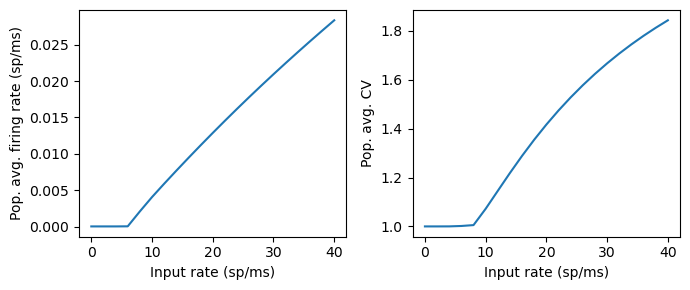

In [108]:
pop_mean = out_mean.mean(1).squeeze()
pop_var = out_var.mean(1).squeeze()
CV = torch.sqrt(out_var/out_mean).mean(1).squeeze()

plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
plt.plot(input_rate_array.squeeze().to('cpu').numpy(), pop_mean.to('cpu').numpy() )
plt.xlabel('Input rate (sp/ms)')
plt.ylabel('Pop. avg. firing rate (sp/ms)')
plt.subplot(1,2,2)
plt.plot(input_rate_array.squeeze().to('cpu').numpy(), CV.to('cpu').numpy() )
plt.xlabel('Input rate (sp/ms)')
plt.ylabel('Pop. avg. CV')
plt.tight_layout()


## Exercises
1. Try simulate the model with different values of `ie_ratio`. Can you use the MNN to explain the synchronous regular and asynchronous irregular regimes reported by Brunel (2000)?
2. Examine the effect of quenched noise (randomn connections) on the firing statistics of individual neurons.
3. How would you code synaptic delay in this model?